In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import numpy as np
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/train_tweets.csv",low_memory=False)
test = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",low_memory=False)

train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,retweet_count,text,encoded_labels
0,569264328186179584,negative,1.0,Cancelled Flight,0.6715,0,@SouthwestAir reservation (FEHQNE) 21FEB15 |...,2
1,569628431236911104,negative,1.0,Can't Tell,0.6567,0,@AmericanAir rented van drove 250 miles with 6...,2
2,567758699574226944,positive,1.0,NaN,NaN,0,@JetBlue @JayVig @roxydigital awww ^_^ R to th...,1
3,567789435795861504,negative,1.0,Customer Service Issue,1.0000,0,@united customer service 👎,2
4,569584207011434497,negative,1.0,Bad Flight,0.6442,0,@USAirways why have me board a plane knowing t...,2


In [ ]:
# train.to_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/train_tweets.csv",index=False)
# test.to_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",index=False)

In [ ]:
print("Here's a neutral tweet: ", train[train['airline_sentiment']=='neutral'].sample(1)['text'].values.item())
print("Here's a positive tweet: ", train[train['airline_sentiment']=='positive'].sample(1)['text'].values.item())
print("Here's a negetive tweet: ", train[train['airline_sentiment']=='negative'].sample(1)['text'].values.item())

Here's a neutral tweet:  @AmericanAir 
Thank you for responding...My laptop is in my bag and I need it for work. I am worried. The file code is UTEVGW.
Here's a positive tweet:  @JetBlue Yesterday on my way from EWR to FLL just after take-off. :)
#wheelsup #JetBlueSoFly http://t.co/9xkiy0Kq2j
Here's a negetive tweet:  @AmericanAir served the nastiest food Ive ever seen yesterday.Rubber chicken in slime. The ENTIRE cabin sent their food back.FAs can confirm


In [ ]:
train.isna().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  4350
negativereason_confidence       3281
retweet_count                      0
text                               0
encoded_labels                     0
dtype: int64

In [ ]:
!pip install -U -q sentence-transformers
!pip install -q nltk
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer


"""
    text pre processing pipeline. keeping it minimal since we want to leverage models
    vocabulary. We will vectorize the input text using BERT and then train a classifier
    on top of it. Before vectorizing, removing stopwords, punctuations are necessary to
    span the latent space properly.
"""

class PreProcess:
    def __init__(self,
                 model_id:str="prajjwal1/bert-small"):
        self.model_id = model_id
        self.model = SentenceTransformer(self.model_id)
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = word_tokenize


    def clean_text(self,text:str)->str:
        """
            Remove special characters, phone numbers,punctuation marks, links, and emails.
            Tokenize & Lemmatize the text
        """
        text = re.sub(r'https?://\S+|www\.\S+|<.*?>|[^A-Za-z0-9]+', ' ', text)
        text = re.sub(r'\b\d{10}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', text)
        tokens = self.tokenizer(text)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join the lemmatized tokens into a string
        cleaned_text = ' '.join(lemmatized_tokens)

        return cleaned_text

    def vectorize(self,text:str)->torch.Tensor:
        """
            Vectorizer function using the sentence transformer
            model.
        """
        return self.model.encode(text)

    def transform(self,text:str)->torch.Tensor:
        """
            The transform method, cleans the input
            text and then vectorizes it using a sentence
            transformer model.
        """
        return self.vectorize(
            self.clean_text(text)
        )


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
_process = PreProcess()

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
print("Text Before cleaning: ",train['text'][8])
print("#####################################")
print("Text after cleaning: ",
      _process.clean_text(train['text'][8]))

Text Before cleaning:  @SouthwestAir @HDsportsguy yes I did. I hope for an update soon, need those clothes for a meeting tomorrow.
#####################################
Text after cleaning:  SouthwestAir HDsportsguy yes I did I hope for an update soon need those clothes for a meeting tomorrow


In [ ]:
sample_text_embedding = _process.transform(train['text'][8])
print(
    f"A sentence embedding of type {type(sample_text_embedding)} and shape {sample_text_embedding.shape} generated using BERT small model."
)

A sentence embedding of type <class 'numpy.ndarray'> and shape (512,) generated using BERT small model.


**Define a classifier head and try to train it with a custom defined parameter that'll callibrate the probablities of the output logits.**

We'll start with having two intermediate layers and one dense layer with one scaling layer to provide the final callibrated softmax probablities.

In [ ]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
    def __init__(self, annotations_file):
        self.transformer = PreProcess()
        self.data = annotations_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.loc[idx, 'encoded_labels']
        text_vector = self.transformer.transform(self.data.loc[idx,'text'])
        return text_vector, label

In [ ]:
from torch.utils.data import DataLoader as dataloader

train_dataloader = dataloader(
    TweetsDataset(train.reset_index(drop=True)),batch_size=16
)

test_dataloader = dataloader(
    TweetsDataset(test.reset_index(drop=True)),batch_size=8
)

In [ ]:
class SentimentClassifier(torch.nn.Module):

    def __init__(self,input_embedd_dim:int,
                 num_labels:int):
        """
            A ANN impletention with dynamic
            probablity callibration during
            training
        """
        super(SentimentClassifier, self).__init__()
        self.init_scaling_factor = torch.ones(num_labels)
        self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)
        self.linear1 = torch.nn.Linear(input_embedd_dim, 64)
        self.dropout = torch.nn.Dropout(p=0.1,inplace=False)
        self.norm1 = torch.nn.BatchNorm1d(64)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, 16)
        self.norm2 = torch.nn.BatchNorm1d(16)
        self.dense = torch.nn.Linear(16,num_labels)


    def forward(self, x):
        """
            The forward pass
        """
        x = self.activation(self.norm1(self.dropout(self.linear1(x))))
        x = self.norm2(self.linear2(x))
        x  = self.dense(x)/self.scaling_factor
        return x

In [ ]:
import torch.nn as nn
import torch.optim as optim

loss = nn.CrossEntropyLoss()
model = SentimentClassifier(input_embedd_dim=512,
                            num_labels=train['airline_sentiment'].nunique())
optimizer = optim.Adam(model.parameters())

def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):
    """
    # Computes accuracy and average confidence for bin

    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels

    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin


def ECE(conf, pred, true, bin_size = 0.1):
    """
    Expected Calibration Error

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        ece: expected calibration error
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins

    n = len(conf)
    ece = 0  # Starting error

    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE

    return ece


def get_bin_info(conf, pred, true, bin_size = 0.1):
    """
    Get accuracy, confidence and elements in bin information for all the bins.

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        (acc, conf, len_bins): tuple containing all the necessary info for reliability diagrams.
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)

    accuracies = []
    confidences = []
    bin_lengths = []

    for conf_thresh in upper_bounds:
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        accuracies.append(acc)
        confidences.append(avg_conf)
        bin_lengths.append(len_bin)


    return accuracies, confidences, bin_lengths

# reliability diagram plotting for subplot case.
def rel_diagram_sub(accs, confs, M = 10, name = "Reliability Diagram", xname = "Confidence", yname="Accuracy",save_name=""):
    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = plt.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = plt.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    plt.gca().set_aspect('equal')
    plt.plot([0,1], [0,1], linestyle = "--")
    plt.legend(handles = [gap_plt, output_plt])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(f"{name}-{save_name.split('.')[0]}", fontsize=24)
    plt.xlabel(xname, fontsize=22, color = "black")
    plt.ylabel(yname, fontsize=22, color = "black")
    plt.savefig(f'/content/drive/MyDrive/Projects/Temperature Scaling of NN/{save_name}', dpi=300)
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
    Placing the model to the GPU/TPU (if available) else CPU
"""
model.to(device)

SentimentClassifier(
  (linear1): Linear(in_features=512, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
def eval_step():
    model.eval()
    test_loss, callibration_error = 0, 0
    # detach the parameter gradients
    with torch.no_grad():
        for eval_idx, eval_batch in tqdm(enumerate(test_dataloader),desc='Eval Step'):
            eval_input = eval_batch[0].to(device)
            eval_labels = eval_batch[1].to(device)
            eval_output = model(eval_input)
            # Get the loss value for the current batch
            loss_val = loss(eval_output,eval_labels)
            test_loss += loss_val.data
            #Get the callibration error for the current batch
            batch_callibration_error = ECE(conf=eval_output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=eval_output.argmax(dim=1),true=eval_labels)
            callibration_error +=  batch_callibration_error
        return test_loss, callibration_error, eval_output, eval_labels

In [ ]:
model.scaling_factor.detach().cpu().numpy()

array([1., 1., 1.], dtype=float32)

In [ ]:
%%time
from tqdm import tqdm

num_epochs = 15
training_loss, callib_error_train,\
 validation_loss, callib_error_test  = [], [], [], []
# track calibration metrics
conf, prediction, true = list(), list(), list()
"""
    The training loop
"""
for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_callibration_error = 0, 0
    for idx, batch in tqdm(enumerate(train_dataloader),desc=f"Epoch {epoch}"):
        input = batch[0].to(device)
        labels = batch[1].to(device)

        """
            Training Step
        """
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(input)
        # Back Propogation Step
        loss_val = loss(output,labels)
        epoch_loss += loss_val.data
        # Calculate the callibration error
        training_batch_callibration_error = ECE(conf=output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=output.argmax(dim=1),true=labels)
        epoch_callibration_error +=  training_batch_callibration_error
        loss_val.backward()
        # Gradient Descent
        optimizer.step()
        # Clamp the temp value towards >1 direction (As suggested by Guo et al.)
        # classmethod for torch.nn.Parameter(1 + torch.sigmoid(model.scaling_factor) * (2 - 1),  requires_grad=True)
        model.scaling_factor.data.clamp_(min=0,max=float('Inf'))
        # break

    training_loss.append(epoch_loss)
    callib_error_train.append(epoch_callibration_error)
    print("Epoch: {}, Training loss: {}, Training Error: {}".format(epoch+1,epoch_loss,epoch_callibration_error))

    """
        Evaluation step
    """
    eval_loss, eval_error, eval_logits, eval_labels = eval_step()
    validation_loss.append(eval_loss)
    callib_error_test.append(eval_error)
    true.append(eval_labels.detach().cpu().numpy())
    conf.append(
        eval_logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy()
        )
    prediction.append(eval_logits.argmax(dim=1).detach().cpu().numpy())
    print("Epoch: {}, Eval loss: {}, Eval Error: {}".format(epoch+1,eval_loss,eval_error))
    # break

print(
    f"Training for {num_epochs} epochs done!!"
)

Epoch 0: 732it [01:13, 10.00it/s]


Epoch: 1, Training loss: 463.29901123046875, Training Error: 143.61262312158942


Eval Step: 366it [00:17, 20.58it/s]


Epoch: 1, Eval loss: 202.62095642089844, Eval Error: 84.3056465126574


Epoch 1: 732it [01:08, 10.66it/s]


Epoch: 2, Training loss: 387.7577209472656, Training Error: 131.9561003781855


Eval Step: 366it [00:16, 21.92it/s]


Epoch: 2, Eval loss: 198.4850311279297, Eval Error: 82.67413202300668


Epoch 2: 732it [01:08, 10.72it/s]


Epoch: 3, Training loss: 363.0552978515625, Training Error: 124.03566663339734


Eval Step: 366it [00:16, 21.87it/s]


Epoch: 3, Eval loss: 200.1997833251953, Eval Error: 82.01006273552775


Epoch 3: 732it [01:08, 10.72it/s]


Epoch: 4, Training loss: 341.7175598144531, Training Error: 121.90678162872791


Eval Step: 366it [00:16, 21.88it/s]


Epoch: 4, Eval loss: 202.80853271484375, Eval Error: 79.52208871021867


Epoch 4: 732it [01:07, 10.78it/s]


Epoch: 5, Training loss: 322.15032958984375, Training Error: 117.43334172479808


Eval Step: 366it [00:16, 21.96it/s]


Epoch: 5, Eval loss: 203.35238647460938, Eval Error: 77.81131167337298


Epoch 5: 732it [01:08, 10.73it/s]


Epoch: 6, Training loss: 303.6856689453125, Training Error: 112.19529908150434


Eval Step: 366it [00:16, 22.21it/s]


Epoch: 6, Eval loss: 208.2954864501953, Eval Error: 76.158696398139


Epoch 6: 732it [01:07, 10.78it/s]


Epoch: 7, Training loss: 280.19683837890625, Training Error: 107.20765545405447


Eval Step: 366it [00:16, 22.20it/s]


Epoch: 7, Eval loss: 224.56008911132812, Eval Error: 77.25198348984122


Epoch 7: 732it [01:07, 10.77it/s]


Epoch: 8, Training loss: 265.5816345214844, Training Error: 104.58368720300496


Eval Step: 366it [00:16, 22.18it/s]


Epoch: 8, Eval loss: 214.96095275878906, Eval Error: 77.45469894632697


Epoch 8: 732it [01:08, 10.75it/s]


Epoch: 9, Training loss: 246.37490844726562, Training Error: 98.33071496151388


Eval Step: 366it [00:16, 22.10it/s]


Epoch: 9, Eval loss: 225.30999755859375, Eval Error: 77.14738597720861


Epoch 9: 732it [01:07, 10.81it/s]


Epoch: 10, Training loss: 228.45701599121094, Training Error: 93.88626393675804


Eval Step: 366it [00:16, 22.11it/s]


Epoch: 10, Eval loss: 238.0276336669922, Eval Error: 77.72254736348987


Epoch 10: 732it [01:08, 10.75it/s]


Epoch: 11, Training loss: 217.59495544433594, Training Error: 89.66781686805189


Eval Step: 366it [00:16, 22.24it/s]


Epoch: 11, Eval loss: 237.7942657470703, Eval Error: 77.0851141102612


Epoch 11: 732it [01:07, 10.82it/s]


Epoch: 12, Training loss: 203.3589630126953, Training Error: 86.26317090913653


Eval Step: 366it [00:16, 22.38it/s]


Epoch: 12, Eval loss: 260.89886474609375, Eval Error: 78.81576581299305


Epoch 12: 732it [01:07, 10.80it/s]


Epoch: 13, Training loss: 190.8990020751953, Training Error: 81.40935121290386


Eval Step: 366it [00:16, 22.18it/s]


Epoch: 13, Eval loss: 265.43914794921875, Eval Error: 78.64870992302895


Epoch 13: 732it [01:07, 10.78it/s]


Epoch: 14, Training loss: 180.28660583496094, Training Error: 79.59931802749634


Eval Step: 366it [00:16, 22.07it/s]


Epoch: 14, Eval loss: 279.3695373535156, Eval Error: 79.59056950733066


Epoch 14: 732it [01:07, 10.88it/s]


Epoch: 15, Training loss: 169.5444793701172, Training Error: 75.29209715127945


Eval Step: 366it [00:16, 21.95it/s]

Epoch: 15, Eval loss: 271.8008728027344, Eval Error: 78.3816545791924
Training for 15 epochs done!!
CPU times: user 20min 45s, sys: 7.24 s, total: 20min 53s
Wall time: 21min 14s


In [ ]:
model.scaling_factor.detach().cpu().numpy()

array([0.8342447 , 0.46633843, 0.61025906], dtype=float32)

In [ ]:
print("Norm of temp vecotr: ",np.linalg.norm(
    model.scaling_factor.detach().cpu().numpy()
))

Norm of temp vecotr:  1.1339542


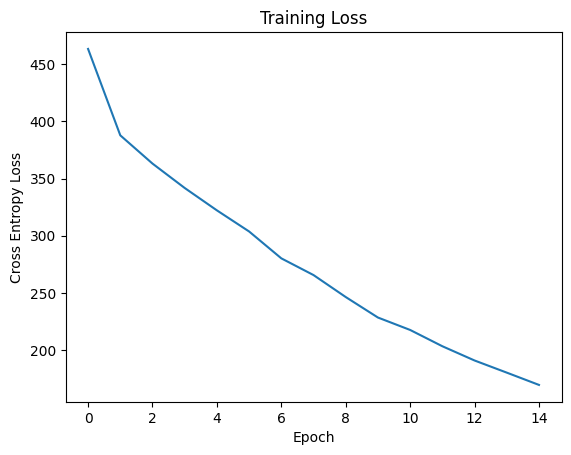

In [ ]:
import matplotlib.pyplot as plt

plt.plot([_loss_.detach().cpu().numpy() for _loss_ in training_loss])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

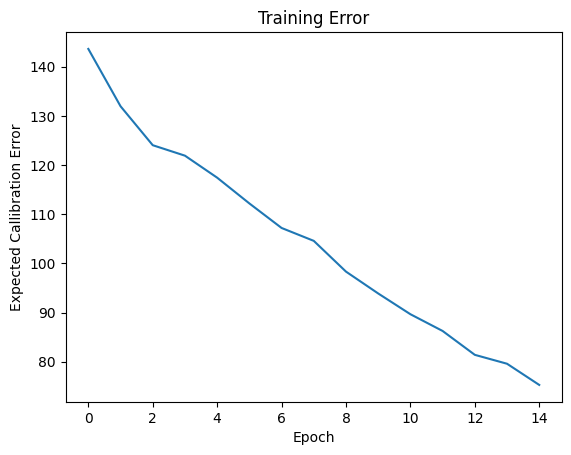

In [ ]:
plt.plot(callib_error_train)
plt.xlabel('Epoch')
plt.ylabel('Expected Callibration Error')
plt.title('Training Error')
plt.show()

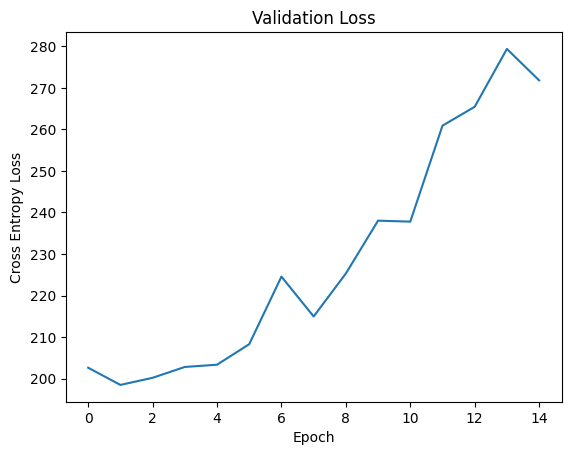

In [ ]:
plt.plot([_loss_.detach().cpu().numpy() for _loss_ in validation_loss])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Validation Loss')
plt.show()

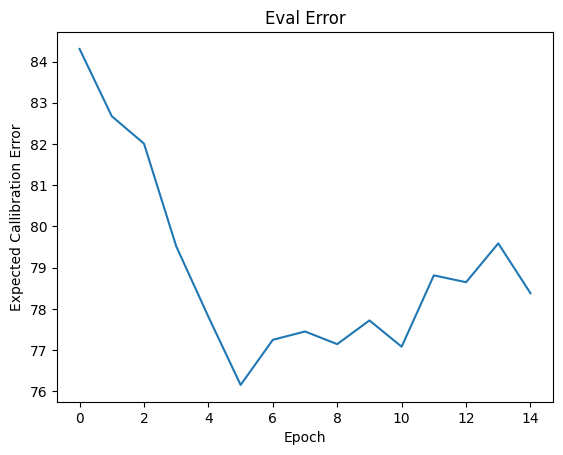

In [ ]:
plt.plot(callib_error_test)
plt.xlabel('Epoch')
plt.ylabel('Expected Callibration Error')
plt.title('Eval Error')
plt.show()

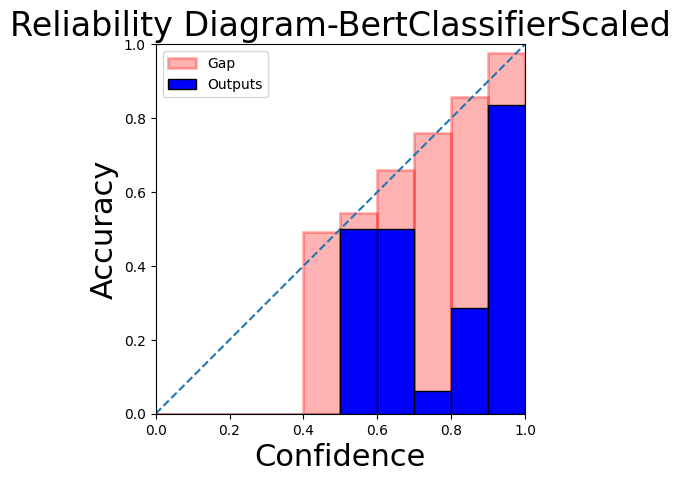

In [ ]:
conf = [j for i in conf for j in i]
prediction = [j for i in prediction for j in i]
true = [j for i in true for j in i]
_acc, _confs, _ = get_bin_info(conf,prediction,true)

# get the reliabilty diagram
rel_diagram_sub(_acc,_confs,save_name="BertClassifierScaled.jpeg")

In [ ]:
metrics_df = pd.merge(
    pd.DataFrame({
    'Loss':[_loss_.detach().cpu().numpy().item() for _loss_ in training_loss],
    'ECE':callib_error_train
}).reset_index(drop=False).rename(columns={'index':'Epoch'}),
    pd.DataFrame({
    'Loss':[_loss_.detach().cpu().numpy().item() for _loss_ in validation_loss],
    'ECE':callib_error_test
}),
    right_index=True,left_index=True,suffixes=("_train","_eval")
)

metrics_df

,Epoch,Loss_train,ECE_train,Loss_eval,ECE_eval
0,0,463.299011,143.612623,202.620956,84.305647
1,1,387.757721,131.956100,198.485031,82.674132
2,2,363.055298,124.035667,200.199783,82.010063
3,3,341.717560,121.906782,202.808533,79.522089
4,4,322.150330,117.433342,203.352386,77.811312
5,5,303.685669,112.195299,208.295486,76.158696
6,6,280.196838,107.207655,224.560089,77.251983
7,7,265.581635,104.583687,214.960953,77.454699
8,8,246.374908,98.330715,225.309998,77.147386
9,9,228.457016,93.886264,238.027634,77.722547


In [ ]:
path = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/Checkpoint_TweetSentimentClassifier.pt'

pd.DataFrame({
    'conf':conf,'pred':prediction,'true':true
}).to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/TweetSentimentClassifierScaledRelDiagData.csv',index=False)
metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/TweetSentimentClassificationMetricsForTempScaledNN.csv',index=False)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)